#### Necessary Libraries

In [66]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
from datetime import datetime
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# feature scaling & OHE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler # data encoders

# moodels 
from sklearn.linear_model import LogisticRegression
# evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, average_precision_score, precision_recall_curve

# resampling techniques for imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler #
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

# formatting 
%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Reading Data 
- Training Datasets: X_train, y_train
- Validation Datasets: X_val, y_val

*Note: they are in a folder one level higher than current folder*

In [67]:
X_train = pd.read_csv('../X_train.csv')
X_val = pd.read_csv('../X_val.csv')
y_train = pd.read_csv('../y_train.csv')
y_val = pd.read_csv('../y_val.csv')

# test set only for one-time assessment of final model
X_test = pd.read_csv('../X_test.csv')
y_test = pd.read_csv('../y_test.csv')

In [68]:
X_train.head()

,hour_of_day,day_of_week,category,gender,age_group,state,job_category,distance,amount(usd)
0,15,Monday,kids_pets,F,21-40,NY,C2,52.770575,75.72
1,10,Tuesday,gas_transport,F,41-60,CA,C2,68.181551,79.74
2,20,Monday,home,M,41-60,MT,C4,66.904380,74.92
3,0,Saturday,gas_transport,F,0-20,IL,C2,65.195819,44.30
4,18,Saturday,home,M,41-60,MD,C2,71.833218,28.02


In [69]:
print("X_train's Shape:",X_train.shape)
print("X_val's Shape:",X_val.shape)
print("X_test's Shape:",X_test.shape)

X_train's Shape: (1481915, 9)
X_val's Shape: (185239, 9)
X_test's Shape: (185240, 9)


#### Local Preprocessing

Creating a **Pipeline*** for the following preprocessing steps:
- Feature Scaling for Numerical Features
- One-Hot Encoding for Categorical Features

****Pipeline()** helps to streamline processes especially since we are refining our models using different techniques like under/oversampling, hyperparameter tuning, etc.*

In [70]:
# numerical features - StandardScaler()
numerical_cols = ['hour_of_day', 'distance', 'amount(usd)']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


# categorical features - OneHotEncoder()
categorical_cols = ['day_of_week', 'category', 'gender','age_group', 'state', 'job_category']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combining preprocessing pipelines for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

#### Helper Functions for Evaluating Model Performance 
a. Evaluate Model using Recall, Precision, F1, Accuracy, ROC AUC, PR AUC

b. Confusion Matrix showing TP,FP,TN,FN

In [71]:
def evaluate_model(y_true, y_pred, y_pred_prob, model_name):
    metrics = {
        'Precision':precision_score(y_true, y_pred),
        'Recall':recall_score(y_true, y_pred),
        'F1 Score':f1_score(y_true, y_pred),
        'PR AUC': average_precision_score(y_true, y_pred_prob), # precision-recall AUC
        'ROC AUC': roc_auc_score(y_true, y_pred_prob)
}

    metrics_df = pd.DataFrame([metrics], index =[model_name])
    return metrics_df

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(model_name)
    plt.show()

#### 1. Baseline Model for Logistic Regression

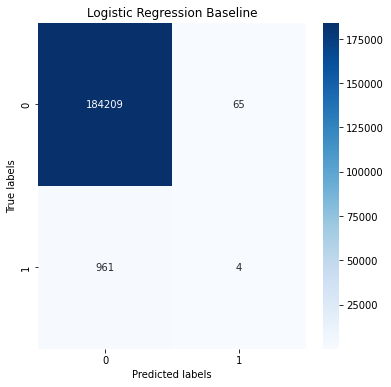

In [72]:
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

base_model.fit(X_train, y_train)

y_val_pred = base_model.predict(X_val)
y_val_pred_prob = base_model.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression Baseline')

In [73]:
base_model_results = evaluate_model(y_true=y_val,
                                    y_pred=y_val_pred, 
                                    y_pred_prob=y_val_pred_prob,
                                    model_name='Logistic Regression Baseline')
base_model_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154


Insights

#### 2. Addressing Class Imbalance 
**a. Synthetic Minority Over-sampling Technique (SMOTE)**

Since our dataset exhibits significant class imbalance (i.e. non-fraudulent >> fraudulent transactions), this can lead to a model being biased towards the majority class, often resulting in poor detection of the minority class (i.e. fraudulent transactions). 

Unlike random oversampling, SMOTE generates synthetic samples rather than simply duplicating existing ones. This approach helps in creating a more diverse and representative sample of the minority class, potentially leading to better generalization Thereby aiding the model in learning patterns specific to fraudulent transactions. Leading to higher recall/sensitivity, making the model more capable of detecting actual fraud cases.

ImbPipeline allows inclusion of resampling step within pipeline, ensuring that resampling only happens during training phase


In [74]:
model_SMOTE = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# train model_SMOTE
model_SMOTE.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'distance',
                                                   'amount(usd)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['day_of_week', 'category',
                                                   'gender', 'age_group',
                                                   'state',
                                                   'job_category'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

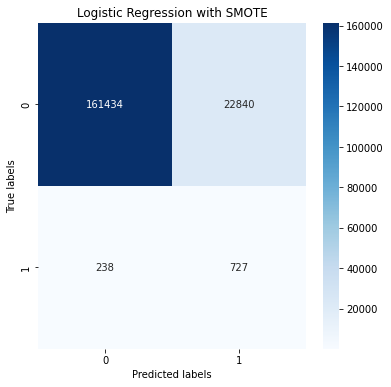

In [75]:
# Predict on the validation set
y_val_pred = model_SMOTE.predict(X_val)
y_val_pred_prob = model_SMOTE.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with SMOTE')

In [76]:
model_SMOTE_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='Logistic Regression with SMOTE')
model_SMOTE_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression with SMOTE,0.030848,0.753368,0.05927,0.149548,0.912696


In [77]:
results_df = pd.concat([base_model_results, model_SMOTE_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154
Logistic Regression with SMOTE,0.030848,0.753368,0.059270,0.149548,0.912696


**b. Random Undersampling**


In [78]:
model_RUS = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# train model_RUS
model_RUS.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'distance',
                                                   'amount(usd)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['day_of_week', 'category',
                                                   'gender', 'age_group',
                                                   'state',
                                                   'job_category'])])),
                ('undersample', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

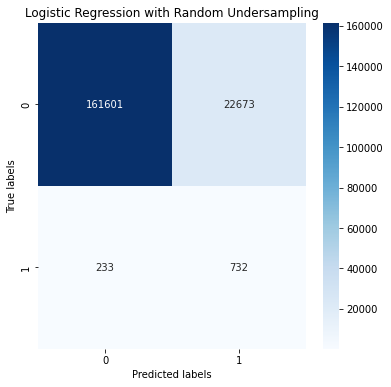

In [79]:
# Predict on the validation set
y_val_pred = model_RUS.predict(X_val)
y_val_pred_prob = model_RUS.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with Random Undersampling')

In [80]:
model_RUS_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='Logistic Regression with Random Undersampling')
model_RUS_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression with Random Undersampling,0.031275,0.758549,0.060074,0.148303,0.912725


In [81]:
results_df = pd.concat([results_df, model_RUS_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154
Logistic Regression with SMOTE,0.030848,0.753368,0.059270,0.149548,0.912696
Logistic Regression with Random Undersampling,0.031275,0.758549,0.060074,0.148303,0.912725


**c. Random Oversampling**

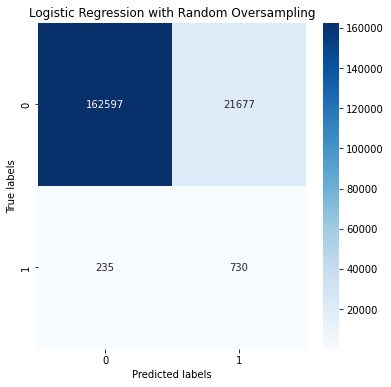

In [82]:
model_ROS = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# train model_ROS
model_ROS.fit(X_train, y_train.values.ravel())  # ensures y_train is in the correct format

# Predict on the validation set
y_val_pred = model_ROS.predict(X_val)
y_val_pred_prob = model_ROS.predict_proba(X_val)[:, 1] # probabilities for ROC AUC

plot_confusion_matrix(y_true=y_val, y_pred=y_val_pred, model_name='Logistic Regression with Random Oversampling')

In [83]:
model_ROS_results = evaluate_model(y_true=y_val,
                             y_pred=y_val_pred, 
                             y_pred_prob=y_val_pred_prob,
                             model_name='Logistic Regression with Random Oversampling')
model_ROS_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression with Random Oversampling,0.032579,0.756477,0.062468,0.150238,0.912446


In [84]:
results_df = pd.concat([results_df, model_ROS_results],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154
Logistic Regression with SMOTE,0.030848,0.753368,0.059270,0.149548,0.912696
Logistic Regression with Random Undersampling,0.031275,0.758549,0.060074,0.148303,0.912725
Logistic Regression with Random Oversampling,0.032579,0.756477,0.062468,0.150238,0.912446


## 3. Threshold Tuning
default threshold for LR = 0.5

a. For Baseline Model

In [85]:
y_val_pred_prob_baseline = base_model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob_baseline)

f1_scores_baseline = 2 * (precision * recall) / (precision + recall)
f1_scores_baseline = np.nan_to_num(f1_scores_baseline) # handles division by zero

best_f1_idx = np.argmax(f1_scores_baseline) # index of highest f1 score
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores_baseline[best_f1_idx]

y_val_pred_adjusted_baseline = (y_val_pred_prob_baseline >= best_threshold).astype(int) # final predictions using the selected threshold

base_model_threshold_tuned = evaluate_model(y_val, y_val_pred_adjusted_baseline, y_val_pred_prob_baseline, 'Logistic Regression Baseline after Tuning Threshold')
base_model_threshold_tuned

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline after Tuning Threshold,0.535191,0.378238,0.44323,0.229586,0.816154


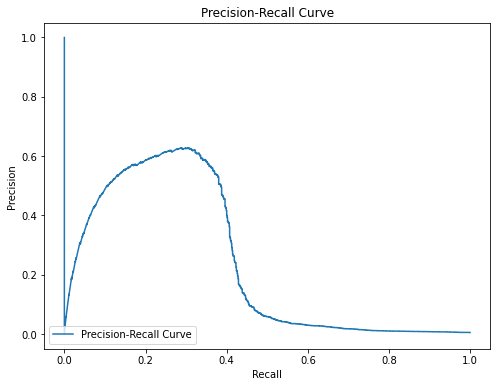

Best Threshold: 0.07070673271326297
Best F1 Score: 0.4432301153612629


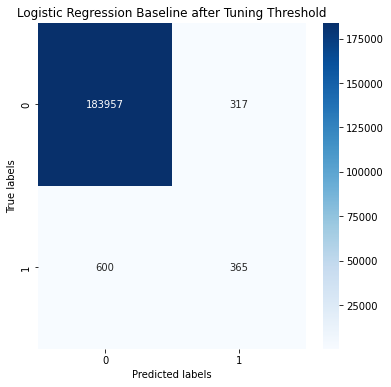

In [86]:
# Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

plot_confusion_matrix(y_val, y_val_pred_adjusted_baseline, 'Logistic Regression Baseline after Tuning Threshold')


In [87]:
results_df = pd.concat([results_df, base_model_threshold_tuned],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154
Logistic Regression with SMOTE,0.030848,0.753368,0.059270,0.149548,0.912696
Logistic Regression with Random Undersampling,0.031275,0.758549,0.060074,0.148303,0.912725
Logistic Regression with Random Oversampling,0.032579,0.756477,0.062468,0.150238,0.912446
Logistic Regression Baseline after Tuning Threshold,0.535191,0.378238,0.443230,0.229586,0.816154


b. For SMOTE model

In [88]:
y_val_pred_prob_smote = model_SMOTE.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob_smote)

f1_scores_smote = 2 * (precision * recall) / (precision + recall)
f1_scores_smote = np.nan_to_num(f1_scores_smote) # handles division by zero

best_f1_idx = np.argmax(f1_scores_smote) # index of highest f1 score
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores_smote[best_f1_idx]

y_val_pred_adjusted_smote = (y_val_pred_prob_smote >= best_threshold).astype(int) # final predictions using the selected threshold

smote_model_threshold_tuned = evaluate_model(y_val, y_val_pred_adjusted_smote, y_val_pred_prob_smote, 'Logistic Regression with SMOTE after Tuning Threshold')
smote_model_threshold_tuned

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression with SMOTE after Tuning Threshold,0.218282,0.618653,0.322703,0.149548,0.912696


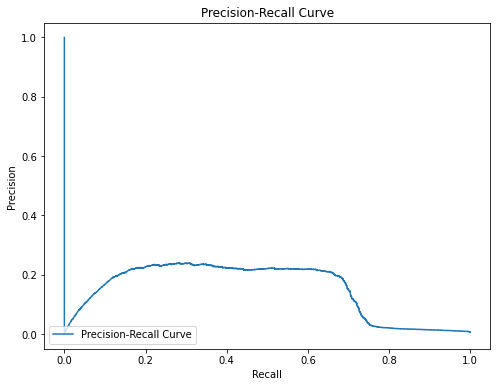

Best Threshold: 0.8271038461636743
Best F1 Score: 0.3227027027027027


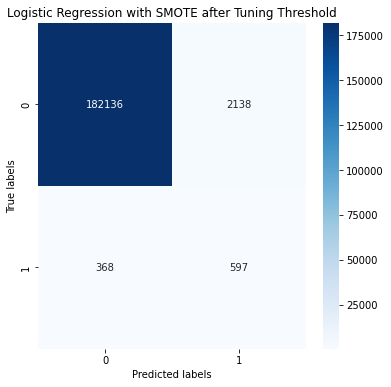

In [89]:
# Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

plot_confusion_matrix(y_val, y_val_pred_adjusted_smote, 'Logistic Regression with SMOTE after Tuning Threshold')


In [90]:
results_df = pd.concat([results_df, smote_model_threshold_tuned],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154
Logistic Regression with SMOTE,0.030848,0.753368,0.059270,0.149548,0.912696
Logistic Regression with Random Undersampling,0.031275,0.758549,0.060074,0.148303,0.912725
Logistic Regression with Random Oversampling,0.032579,0.756477,0.062468,0.150238,0.912446
Logistic Regression Baseline after Tuning Threshold,0.535191,0.378238,0.443230,0.229586,0.816154
Logistic Regression with SMOTE after Tuning Threshold,0.218282,0.618653,0.322703,0.149548,0.912696


c. For Random Undersampling Model

In [91]:
y_val_pred_prob_rus = model_RUS.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob_rus)

f1_scores_rus = 2 * (precision * recall) / (precision + recall)
f1_scores_rus = np.nan_to_num(f1_scores_rus) # handles division by zero

best_f1_idx = np.argmax(f1_scores_rus) # index of highest f1 score
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores_rus[best_f1_idx]

y_val_pred_adjusted_rus = (y_val_pred_prob_rus >= best_threshold).astype(int) # final predictions using the selected threshold

rus_model_threshold_tuned = evaluate_model(y_val, y_val_pred_adjusted_rus, y_val_pred_prob_rus, 'Logistic Regression with Random Undersampling after Tuning Threshold')
rus_model_threshold_tuned

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression with Random Undersampling after Tuning Threshold,0.209396,0.646632,0.31635,0.148303,0.912725


d. For Random Oversampling Model

In [92]:
y_val_pred_prob_ros = model_ROS.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob_ros)
 
f1_scores_ros = 2 * (precision * recall) / (precision + recall)
f1_scores_ros = np.nan_to_num(f1_scores_ros) # handles division by zero

best_f1_idx = np.argmax(f1_scores_ros) # index of highest f1 score
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores_ros[best_f1_idx]

y_val_pred_adjusted_ros = (y_val_pred_prob_ros >= best_threshold).astype(int) # final predictions using the selected threshold

ros_model_threshold_tuned = evaluate_model(y_val, y_val_pred_adjusted_ros, y_val_pred_prob_ros, 'Logistic Regression with Random Oversamlping after Tuning Threshold')
ros_model_threshold_tuned

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression with Random Oversamlping after Tuning Threshold,0.211024,0.670466,0.321012,0.150238,0.912446


In [93]:
best_threshold

0.7906691000391646

In [94]:
results_df = pd.concat([results_df, rus_model_threshold_tuned],axis=0)
results_df = pd.concat([results_df, ros_model_threshold_tuned],axis=0)
results_df

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Logistic Regression Baseline,0.057971,0.004145,0.007737,0.229586,0.816154
Logistic Regression with SMOTE,0.030848,0.753368,0.059270,0.149548,0.912696
Logistic Regression with Random Undersampling,0.031275,0.758549,0.060074,0.148303,0.912725
Logistic Regression with Random Oversampling,0.032579,0.756477,0.062468,0.150238,0.912446
Logistic Regression Baseline after Tuning Threshold,0.535191,0.378238,0.443230,0.229586,0.816154
Logistic Regression with SMOTE after Tuning Threshold,0.218282,0.618653,0.322703,0.149548,0.912696
Logistic Regression with Random Undersampling after Tuning Threshold,0.209396,0.646632,0.316350,0.148303,0.912725
Logistic Regression with Random Oversamlping after Tuning Threshold,0.211024,0.670466,0.321012,0.150238,0.912446


## One-Time Assessment of Best LR Model on Testing Set
To understand model performance on unseen data.

In [95]:
best_lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

best_lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'distance',
                                                   'amount(usd)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['day_of_week', 'category',
                                                   'gender', 'age_group',
                                                   'state',
                                                   'job_category'])])),
                ('classifier', LogisticRegression(random_state=42))])

Evaluate on Testing Set

In [96]:
y_test_pred = best_lr_model.predict(X_test)
y_test_pred_prob = best_lr_model.predict_proba(X_test)[:, 1] # probabilities for ROC AUC

In [97]:
best_threshold = 0.7906691000391646
y_test_pred_adjusted = (y_test_pred_prob >= best_threshold).astype(int)

In [98]:
# evaluation metrics for the best model
best_lr_model_results = evaluate_model(y_true=y_test,
                                        y_pred=y_test_pred_adjusted, 
                                        y_pred_prob=y_test_pred_prob,
                                        model_name='Best LR Model (Base Model with Threshold Tuned)')
best_lr_model_results

,Precision,Recall,F1 Score,PR AUC,ROC AUC
Best LR Model (Base Model with Threshold Tuned),0.0,0.0,0.0,0.243331,0.825866
